# Portfolio-Exam Machine Learning

Gesundheitszustand anhand der Metriken bewerten die man z.B. auch mit einem Handy ausmessen kann wie bspw. schlaf, schritte am tag, hf, rr, alkoholkonsum, rauchen

In [28]:
import pandas as pd

In [3]:

# https://www.cdc.gov/brfss/annual_data/annual_2022.html Data Source
# https://www.cdc.gov/brfss/annual_data/2020/pdf/2020-calculated-variables-version4-508.pdf

df = pd.read_sas("LLCP2022.XPT")

In [25]:
df.head()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,_SMOKGRP,_LCSREC,DRNKANY6,DROCDY4_,_RFBING6,_DRNKWK2,_RFDRHV8,_FLSHOT7,_PNEUMO3,_AIDTST4
0,1.0,1.0,b'02032022',b'02',b'03',b'2022',1100.0,b'2022000001',2.022000e+09,1.0,...,4.0,NaN,2.0,5.397605e-79,1.0,5.397605e-79,1.0,1.0,2.0,2.0
1,1.0,1.0,b'02042022',b'02',b'04',b'2022',1100.0,b'2022000002',2.022000e+09,1.0,...,4.0,NaN,2.0,5.397605e-79,1.0,5.397605e-79,1.0,2.0,2.0,2.0
2,1.0,1.0,b'02022022',b'02',b'02',b'2022',1100.0,b'2022000003',2.022000e+09,1.0,...,4.0,NaN,2.0,5.397605e-79,1.0,5.397605e-79,1.0,NaN,NaN,2.0
3,1.0,1.0,b'02032022',b'02',b'03',b'2022',1100.0,b'2022000004',2.022000e+09,1.0,...,3.0,2.0,2.0,5.397605e-79,1.0,5.397605e-79,1.0,9.0,9.0,2.0
4,1.0,1.0,b'02022022',b'02',b'02',b'2022',1100.0,b'2022000005',2.022000e+09,1.0,...,4.0,NaN,1.0,1.000000e+01,1.0,1.400000e+02,1.0,NaN,NaN,2.0


In [5]:
df.memory_usage(index=True).sum()

1168026496

<Axes: ylabel='Frequency'>

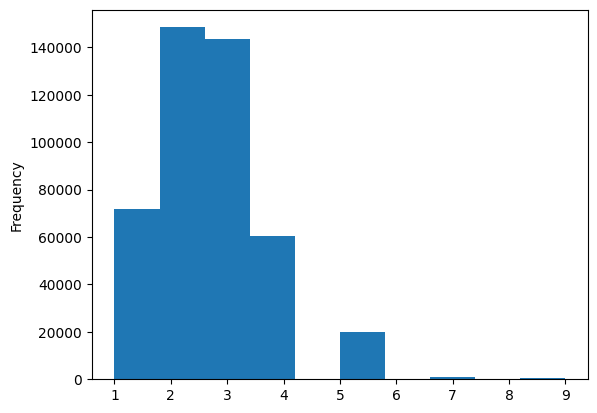

In [6]:
df["GENHLTH"].plot.hist()

<Axes: ylabel='Frequency'>

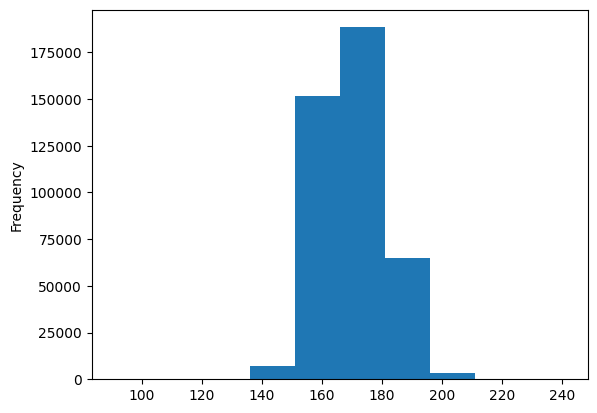

In [7]:
df["HTM4"].plot.hist()

<Axes: ylabel='Frequency'>

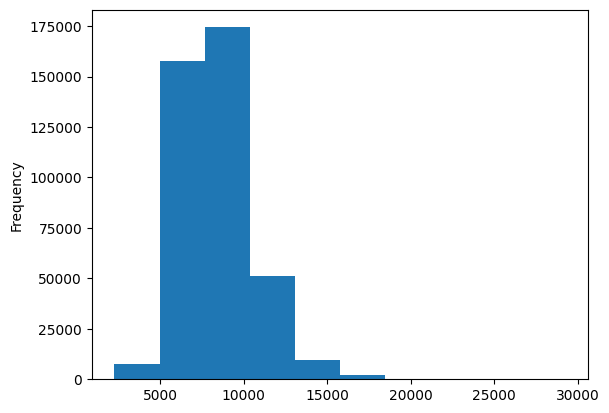

In [8]:
df["WTKG3"].plot.hist()

<Axes: ylabel='Frequency'>

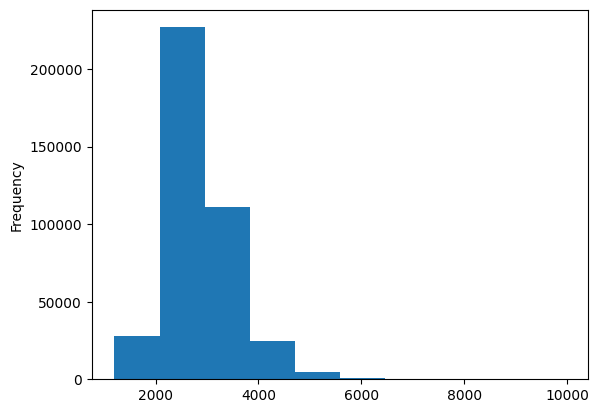

In [9]:
df["_BMI5"].plot.hist()

<Axes: ylabel='Frequency'>

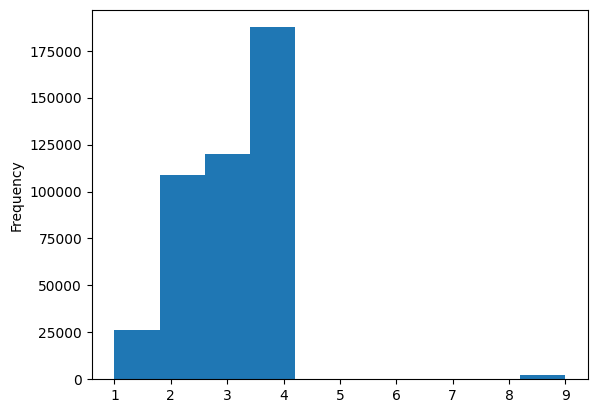

In [10]:
df["_EDUCAG"].plot.hist()

<Axes: ylabel='Frequency'>

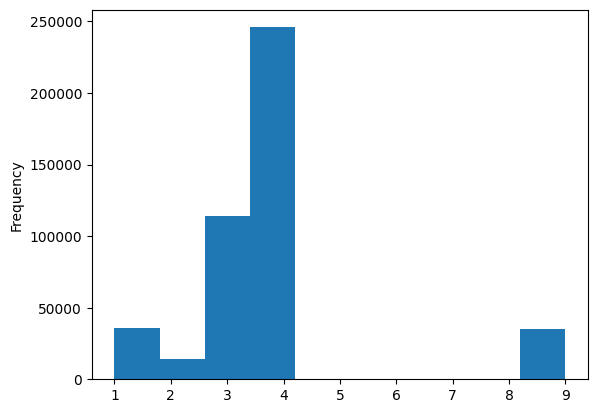

In [22]:
df["_SMOKER3"].plot.hist()

<Axes: ylabel='Frequency'>

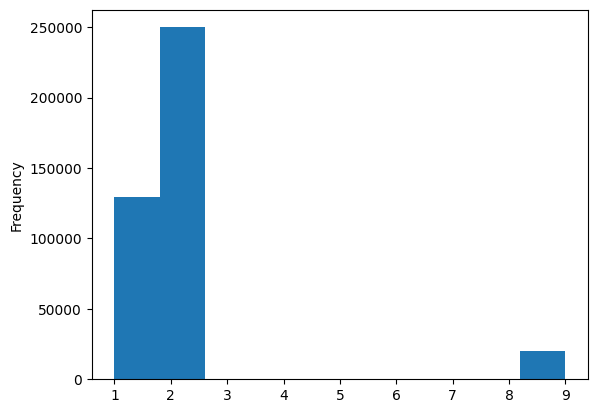

In [27]:
df["_AIDTST4"].plot.hist()

# Testing with cross validation

In [33]:
import numpy as np
# !pip install scikit-learn
from sklearn import linear_model, tree, ensemble
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score

In [39]:
from sklearn import datasets
data = datasets.load_digits()

# transfrm the data into a dataframe
df = pd.DataFrame(data.data, columns=data.feature_names)

In [45]:
# LETS SPLIT THE DATA INTO 3 FOLDS :)!

kf = KFold(n_splits=3, shuffle=True, random_state=69)

cnt = 1
for train_index, test_index in kf.split(df):
    print(f"Fold:{cnt}, Train set: {len(train_index)}, Test set: {len(test_index)}")
    cnt += 1

Fold:1, Train set: 1198, Test set: 599
Fold:2, Train set: 1198, Test set: 599
Fold:3, Train set: 1198, Test set: 599


In [53]:
score = cross_val_score(tree.DecisionTreeRegressor(random_state=69), df, data.target, cv=kf, scoring="neg_mean_squared_error")
print(f"Root Mean Squared Error: {score}")
print(f"Average RMSE: {score.mean()}")

Root Mean Squared Error: [-3.07011686 -3.15358932 -3.15191987]
Average RMSE: -3.1252086811352253


In [59]:
max_depth = np.arange(1, 11)

In [60]:
for val in max_depth:
    score = cross_val_score(tree.DecisionTreeRegressor(random_state=69, max_depth=val), df, data.target, cv=kf, scoring="neg_mean_squared_error")
    print(f"Max Depth: {val}, Average RMSE: {score.mean()}")

Max Depth: 1, Average RMSE: -7.270570636045252
Max Depth: 2, Average RMSE: -6.281110355086928
Max Depth: 3, Average RMSE: -4.801281611119597
Max Depth: 4, Average RMSE: -4.043570855718557
Max Depth: 5, Average RMSE: -3.559347453156444
Max Depth: 6, Average RMSE: -3.3116924421434653
Max Depth: 7, Average RMSE: -3.085843088301255
Max Depth: 8, Average RMSE: -3.148491060981365
Max Depth: 9, Average RMSE: -3.0924997013329345
Max Depth: 10, Average RMSE: -3.147400481683246


# nested cross validation 
now we do it but with inner and outer circles
so we do it arround itself not only once but twice

In [61]:
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.svm import SVC

In [71]:
# num of random trails
NUM_TRIALS = 3
NUM_SPLITS = 3

svm = SVC(kernel="rbf")

non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)
p_grid = {"C": [1e-1, 1e0, 1e1, 1e2], "gamma": np.logspace(-2, 2, 5)}

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold

See also:
StratifiedKFold

    Takes class information into account to avoid building folds with imbalanced class distributions (for binary or multiclass classification tasks).
GroupKFold

    K-fold iterator variant with non-overlapping groups.
RepeatedKFold

    Repeats K-Fold n times.



In [77]:
for i in range(NUM_TRIALS):
    print(f"Running Outer CV in iteration {i}")

    # pipe = get_pipe(estimator)

    inner_cv = KFold(NUM_SPLITS, shuffle=True, random_state=i) # into repeatedstratifiedkfold
    outer_cv = KFold(NUM_SPLITS, shuffle=True, random_state=i) #normal stratified kfold since in for loop

    clf = GridSearchCV(estimator=svm, cv=outer_cv, param_grid=p_grid) # meta classifier

    # problem without the pipeline -> scaling inside the pipeline and not just on the whole dataset
    #cross_validate executes the outer cross validation -> so also the inner cross validation
    


    clf.fit(df, data.target)
    non_nested_scores[i] = clf.best_score_

    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=inner_cv)
    nested_scores = cross_val_score(clf, df, data.target, cv=outer_cv)
    nested_scores[i] = nested_scores.mean()

score_difference = non_nested_scores - nested_scores

Running Outer CV in iteration 0
Running Outer CV in iteration 1
Running Outer CV in iteration 2


what is the param_grid?
was is "scoring"?

In [73]:
non_nested_scores

array([0.75459098, 0.77740679, 0.74902615])

In [74]:
nested_scores

array([0.75292154, 0.79465776, 0.74902615])

In [75]:
score_difference

array([ 0.00166945, -0.01725097,  0.        ])

In [76]:
print(
    "Average difference of {:6f} with std. dev. of {:6f}.".format(
        score_difference.mean(), score_difference.std()
    )
)

Average difference of -0.005194 with std. dev. of 0.008553.


sklearn Pipeline to combinde stuff

gridsearchCV -> grid search in cv


KFold -> different kind of cross validations


programm it yourself or use kfold and parameterise it in the way you want


Setting global Config -- no magic numbers??
-> preventing magic numbers from happening not to use numbers out of context
NUM_TRIALS
NUM_INNER REPEATS
NUM INNER SPLITS
NUM OUTER SPLITS

what is the grid
- represent all combinations of hypercombinators we want to test
- the underscores are there for the pipelines __
- different hyperparameters for different methods
*grid* -> list of every combination possible 

in scalers we have fit/transorm or fit-transform

fit -> scales the data

helperfunction to create pipelines always in the same way -> get_pipeline returns pipeline with different steps


crossvalidation -> slipt into test/data _> every role gets to play test/train once 
repCV -> doing cross validation with different folds, repeating the whole cross validation

[1,2,3,4,5,6]
split in 3:
[1,2],[3,4],[4,5]
[1,6],[3,6],[2,4]


bacc = mean over the 9 outer layers

plotting bacc over c -> shows how stable a algorithm is, we do not see how influencial the hyperparameters are